# Dataset was retrieved from
https://www.kaggle.com/datasets/chandramoulinaidu/spam-classification-for-basic-nlp/code



First off, we will be installing libraries as these will be used throughout the implementation of the ML process.

In [1]:
#!pip install matplotlib
#!pip install seaborn
#!pip install sklearn
#!pip install boto3

Next, we will be importing these libraries to the notebook file to make the functions and processes of each library accessible.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sagemaker
import json
import nltk
nltk.download("punkt")

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import image_uris

%matplotlib inline

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Next would be importing the dataset (as csv) from amazon s3 into the notebook file.

In [3]:
import pickle
import boto3
import io

my_bucket = 'iscs-3020-dataset'
my_file = 'Spam Email raw text for NLP.csv'
s3client = boto3.client('s3')
response = s3client.get_object(Bucket=my_bucket, Key=my_file)
data = pd.read_csv(io.BytesIO(response['Body'].read()))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


For the next couple of lines, we will be checking the shape of the dataset through shape (instances, features), checking for null values, and checking a few of the values that are in the dataset. We will also be checking how the dataset is distributed -- how much are spam emails and how much are non-spam emails through it's feature 'category', which will be visualized by matplotlib

In [4]:
#checking the shape
print(data.shape)

(5796, 3)


In [5]:
#checking for null values
data.isna().sum()

CATEGORY     0
MESSAGE      0
FILE_NAME    0
dtype: int64

In [6]:
#checking for the first few lines/entries in the dataset
data.head()

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


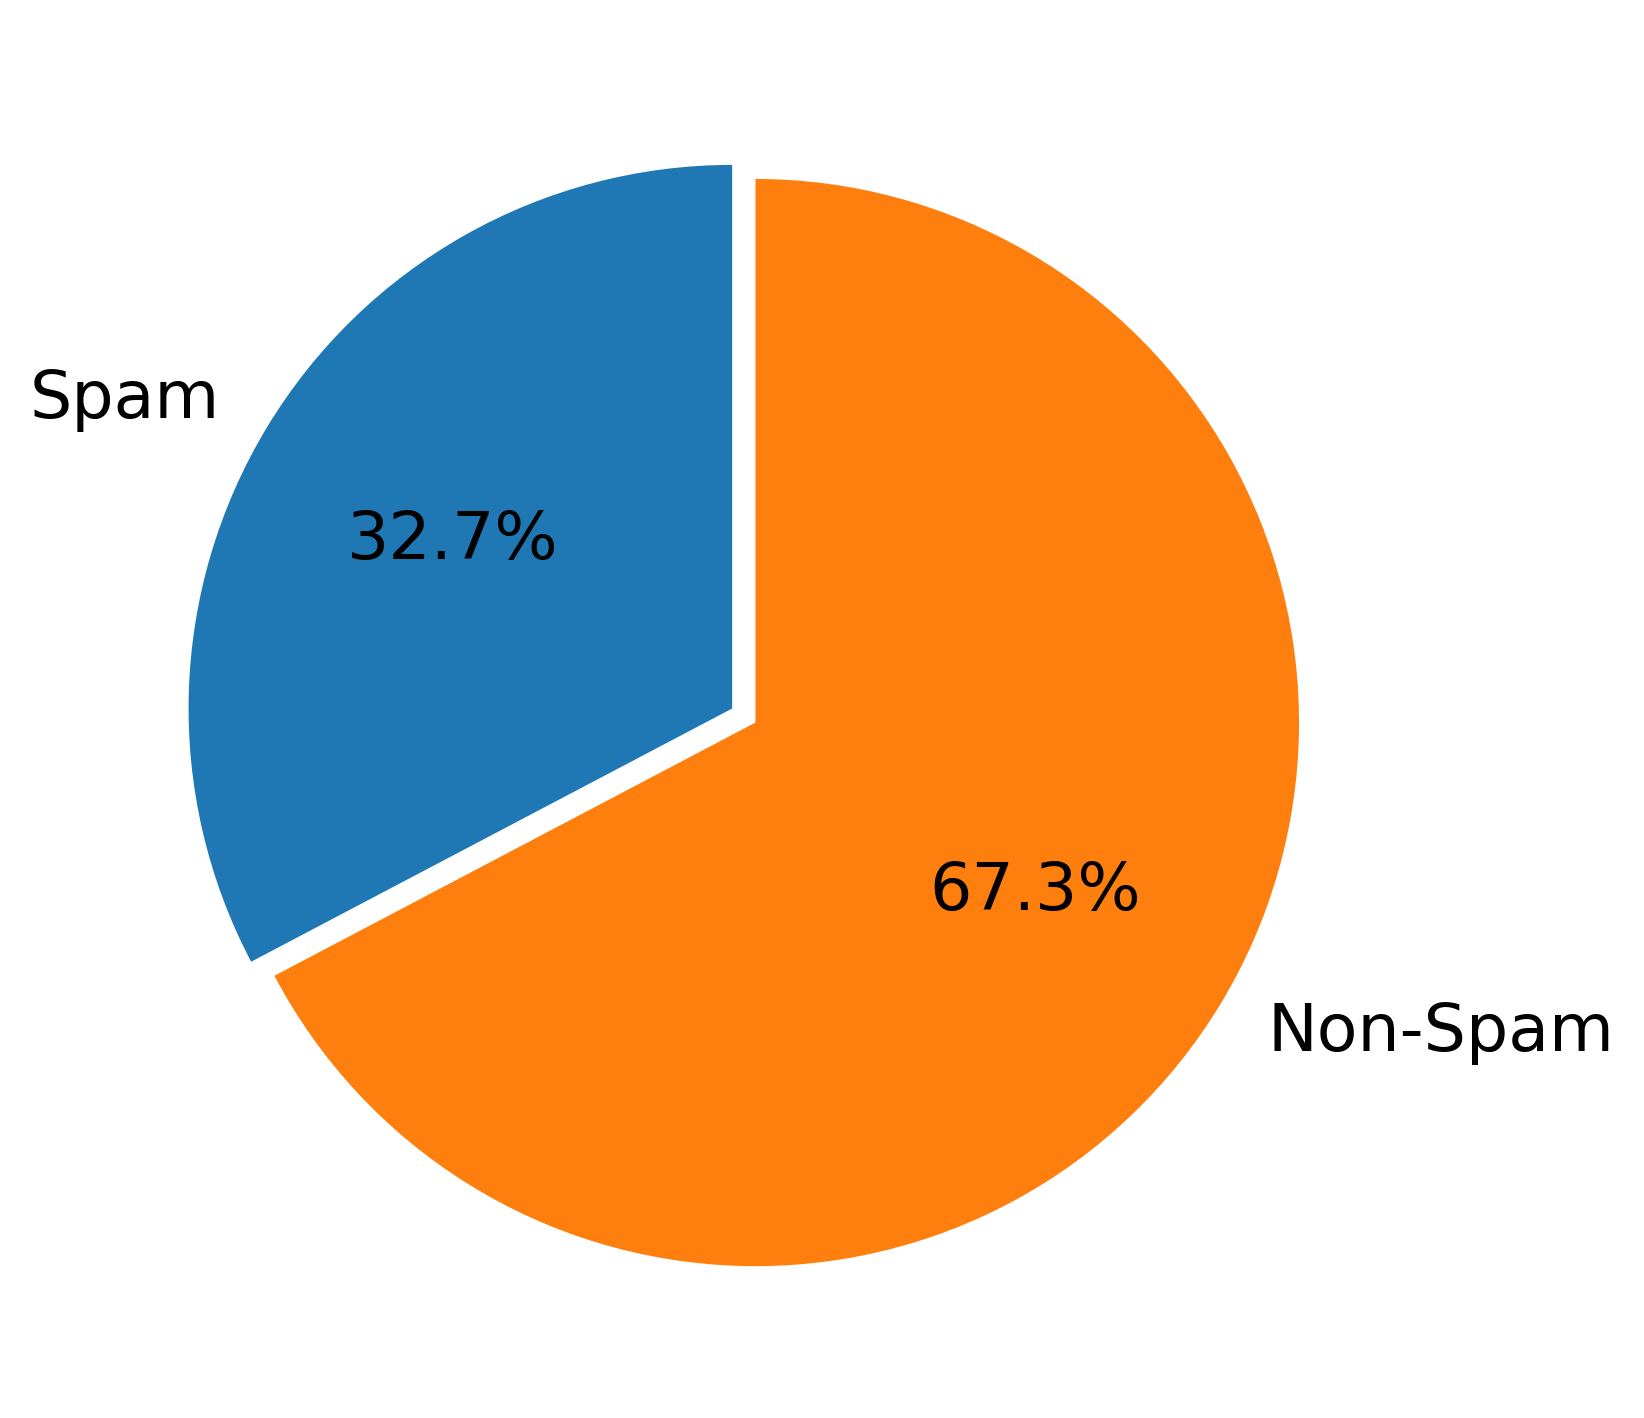

In [7]:
#checking data distribution
pieChartLabels = ['Spam', 'Non-Spam']
sizeOfDataSet = [data.CATEGORY.value_counts()[1], data.CATEGORY.value_counts()[0]]
plt.figure(figsize=(6,6), dpi = 300)
plt.pie(sizeOfDataSet, labels=pieChartLabels, textprops={'fontsize':16}, startangle=90, autopct='%1.1f%%',
       explode=[0,0.05])
plt.show()

# Data Pre-processing
In this part, we will be preprocesing the data to make sure that the input to the machine will be as straightforward as possible. This includes removing special characters/symbols in the text, removing duplicate entries through the feature 'FILE_NAME'.

In [8]:
#removes duplicate data (if ever) in the dataset through checking the uniqueness of values under the feature 'FILE_NAME'
df = data
df = df.reset_index()

uniqueFileName = []
indexedMessageAttribute = []
indexedCategoryAttribute = []
for index, row in df.iterrows():
    if row['FILE_NAME'] in uniqueFileName:
        continue
    else:
        indexedMessageAttribute.append(row['MESSAGE'])
        indexedCategoryAttribute.append(row['CATEGORY'])
        uniqueFileName.append(row['FILE_NAME'])

In [9]:
#creates a method in cleaning the text or inputs under the feature 'MESSAGE'
def CleanMessage(stringInput):
    tag = False
    punctuations = '''!()-+=[]{};:'"\,./?@#$%^&*_~'''
    stringOutput = ''
    stringInputList = stringInput.split(" ")
    
    for i in stringInputList: 
        stringTemp = ''
        for char in i:
            if char not in punctuations:
                stringTemp += char;
        stringTemp = stringTemp.lower()
        
        if stringTemp.isnumeric():
            stringTemp = ''
        if '\n' in stringTemp:
            stringTemp = stringTemp.replace("\n", " ")
        if 'http' in stringTemp:
            stringTemp = ''

        if tag:
            stringOutput = stringOutput
        else:
            stringOutput += stringTemp + " "
    
    returnString = ''
    for char in stringOutput:
        if char == "<":
            tag = True
        elif char == ">":
            tag = False
            continue
        if char == " ":
            if (len(returnString) > 1) and returnString[-1] == " ":
                char = ''
        if not tag:
            returnString += char
    
    return returnString

In [10]:
cleanedMessage = []
for entry in indexedMessageAttribute:
    cleanedMessage.append(CleanMessage(entry))

In [11]:
toData = []
for appearances in cleanedMessage:
    if indexedCategoryAttribute[cleanedMessage.index(appearances)] == 0:
        toData.append(["__label__0", appearances])
    else:
        toData.append(["__label__1", appearances])

In [12]:
newData = pd.DataFrame(toData, columns = ['CATEGORY', 'MESSAGE'])
ndf = newData
ndf = ndf.reset_index()

In [13]:
newData.shape

(5796, 2)

In [14]:
newData.head()

,CATEGORY,MESSAGE
0,__label__1,dear homeowner interest rates are at their low...
1,__label__1,attention this is a must for all computer user...
2,__label__1,this is a multipart message in mime format nex...
3,__label__1,important information the new domain names are...
4,__label__1,this is the bottom line if you can give away c...


In [15]:
#separates the spam from the non-spams for visualization of the top words in each category
spamList = []
nonSpamList = []

for index, row in ndf.iterrows():
    if(row['CATEGORY'] == "__label__1"):
        spamList.append(row['MESSAGE'])
    else:
        nonSpamList.append(row['MESSAGE'])

In [16]:
#creates a method/function that checks the top 10 words which are used by the list of words, implemented through the bag of words model
def GetTop10Results(listOfWords):
    vec = CountVectorizer().fit(listOfWords)
    bagOfWords = vec.transform(listOfWords)
    sumWords = bagOfWords.sum(axis = 0)
    wordsFrequency = [(word, sumWords[0, idx]) for word, idx in vec.vocabulary_.items()]
    wordsFrequency = sorted(wordsFrequency, key = lambda x: x[1], reverse = True)
    return wordsFrequency[:10]

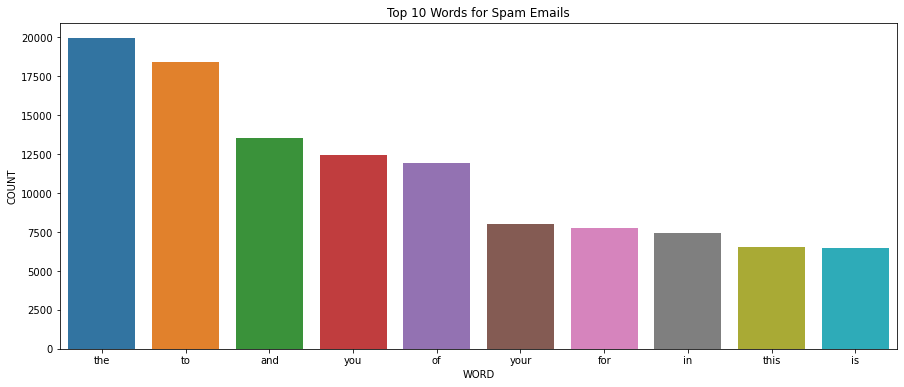

In [17]:
#checks the top 10 words that spam emails use and creates a visualization through matplotlib
commonWords = GetTop10Results(spamList)
top10Data = pd.DataFrame(commonWords, columns = ['WORD', 'COUNT'])
plt.figure(figsize=(15,6))
sns.barplot(data = top10Data.reset_index(), x = 'WORD', y = 'COUNT')
plt.title('Top 10 Words for Spam Emails')
plt.show()

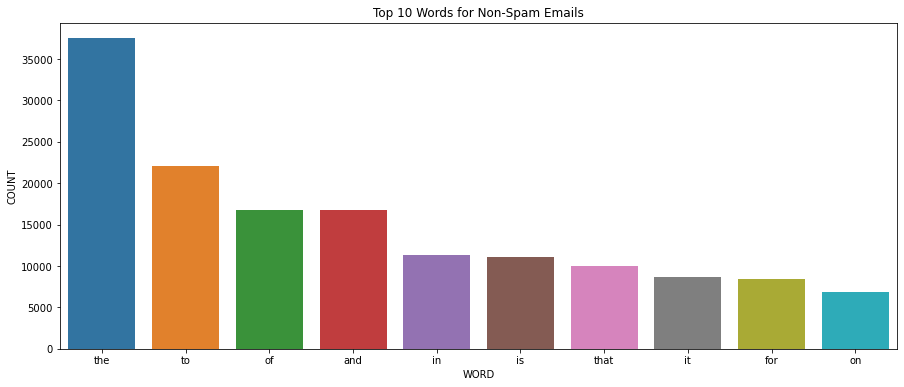

In [18]:
#checks the top 10 words that non-spam emails use
commonWords = GetTop10Results(nonSpamList)
top10Data = pd.DataFrame(commonWords, columns = ['WORD', 'COUNT'])
plt.figure(figsize=(15,6))
sns.barplot(data = top10Data.reset_index(), x = 'WORD', y = 'COUNT')
plt.title('Top 10 Words for Non-Spam Emails')
plt.show()

In [19]:
newData

,CATEGORY,MESSAGE
0,__label__1,dear homeowner interest rates are at their low...
1,__label__1,attention this is a must for all computer user...
2,__label__1,this is a multipart message in mime format nex...
3,__label__1,important information the new domain names are...
4,__label__1,this is the bottom line if you can give away c...
...,...,...
5791,__label__0,im one of the but its not working very well th...
5792,__label__0,damien morton quoted w3c approves html emotita...
5793,__label__0,on mon at che wrote thats the correct lines to...
5794,__label__0,once upon a time manfred wrote i would like to...


In [20]:
trainSpam, testSpam = train_test_split(newData,
                                           test_size=0.2,
                                           stratify=newData['CATEGORY'])

In [21]:
trainSpam.to_csv('Train Spam Emails.csv', index=False, header=True)
testSpam.to_csv('Test Spam Emails.csv', index=False, header=True)

# Model Training

In [22]:
sess = sagemaker.Session()
role = get_execution_role()
#my_bucket = 'iscs-3020-dataset'
prefix = "blazingtext/supervised"

region_name = boto3.Session().region_name
container = image_uris.retrieve('blazingtext', boto3.Session().region_name)

In [23]:
trainChannel = prefix + "/train"
validationChannel = prefix + "/validation"

sess.upload_data(path="Train Spam Emails.csv", bucket=my_bucket, key_prefix=trainChannel)
sess.upload_data(path="Test Spam Emails.csv", bucket=my_bucket, key_prefix=validationChannel)

s3_train_data = 's3://{}/{}'.format(my_bucket, trainChannel)
s3_validation_data = 's3://{}/{}'.format(my_bucket, validationChannel)

In [24]:
s3_output_location = 's3://{}/{}/output'.format(my_bucket, prefix)

In [25]:
bt_model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type='ml.c5.xlarge',
    volume_size=11,
    max_run=5000,
    output_path=s3_output_location
)

In [26]:
bt_model.set_hyperparameters(
    mode="supervised",
    epochs=1,
    min_count=2,
    learning_rate=0.01,
    vector_dim=3,
    early_stopping=True,
    patience=2,
    min_epochs=5,
    word_ngrams=2
)

In [27]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)

validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {'train': train_data, "validation": validation_data}

In [28]:
bt_model.fit(inputs=data_channels, logs=True)

2022-05-29 13:51:48 Starting - Starting the training job...
2022-05-29 13:52:12 Starting - Preparing the instances for trainingProfilerReport-1653832308: InProgress
......
2022-05-29 13:53:13 Downloading - Downloading input data...
2022-05-29 13:53:44 Training - Training image download completed. Training in progress..Arguments: train
[05/29/2022 13:53:47 WARNING 139909038065472] Loggers have already been setup.
[05/29/2022 13:53:47 WARNING 139909038065472] Loggers have already been setup.
[05/29/2022 13:53:47 INFO 139909038065472] nvidia-smi took: 0.025226116180419922 secs to identify 0 gpus
[05/29/2022 13:53:47 INFO 139909038065472] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[05/29/2022 13:53:47 INFO 139909038065472] Processing /opt/ml/input/data/train/Train Spam Emails.csv . File size: 7.585992813110352 MB
[05/29/2022 13:53:47 INFO 139909038065472] Processing /opt/ml/input/data/validation/Test Spam Emails.csv 

# Model Evaluation

In [29]:
test, validation = train_test_split(testSpam,
                                        test_size=0.5,
                                        stratify=testSpam['CATEGORY'])

In [30]:
sentences = []
labels = []

for index, row in test.iterrows():
    sentences.append(row['MESSAGE'])
    labels.append(row['CATEGORY'])

In [31]:
bt_model.latest_training_job.wait(logs=False)
bt_model.training_job_analytics.dataframe()


2022-05-29 13:54:12 Starting - Preparing the instances for training
2022-05-29 13:54:12 Downloading - Downloading input data
2022-05-29 13:54:12 Training - Training image download completed. Training in progress.
2022-05-29 13:54:12 Uploading - Uploading generated training model
2022-05-29 13:54:12 Completed - Training job completed


,timestamp,metric_name,value
0,0.0,train:accuracy,0.1531
1,0.0,validation:accuracy,0.1615


In [39]:
from sagemaker.serializers import JSONSerializer

text_classifier = bt_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    serializer=JSONSerializer())

-------!

In [40]:
text_classifier.endpoint_name

'blazingtext-2022-05-29-14-01-18-728'

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

tokenized_sentences = [" ".join(nltk.word_tokenize(sent)) for sent in sentences]

payload = {"instances": tokenized_sentences}

response = text_classifier.predict(payload)
predictions = json.loads(response)

#print(json.dumps(predictions, indent=2))

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

cm = np.zeros((2,2), dtype=int)

label_map = {"__label__0": 0, "__label__1": 1}
i = 0
for l in labels:
    actual = l
    predicted = predictions[i]['label'][0]
    
    commaIndex = predicted.index(",")
    predicted = predicted[:commaIndex]
    
    act_idx = label_map[actual]
    pre_idx = label_map[predicted]
    cm[act_idx, pre_idx] += 1
    i += 1

print(cm)    


# 0 is real email
# 1 is spam email

trueNegative = cm[0][0]
falseNegative = cm[0][1]
falsePositive = cm[1][0]
truePositive = cm[1][1]

sensitivity = truePositive / (truePositive + falseNegative)
specificity = trueNegative / (trueNegative + falsePositive)
accuracy = (truePositive + trueNegative) / (truePositive + trueNegative + falsePositive + falseNegative)
precision = truePositive / (truePositive + falsePositive)
recall = truePositive / (truePositive + falseNegative)
fOneScore = (2 * precision * recall) / (precision + recall)

#sensitivity = tp / (tp + fn)
#[sensitivity] of spams were detected as spams

#specificity = tn / (tn + fp)
#[specificity]] of not spams were identified as not spam

#accuracy = (tp + tn) / (tp + tn + fp + fn)

#precision = tp / (tp + fp)

#recall = tp / (tp + fn)

#f1-score = (2*precision * recall) / (precision + recall)

[[245 145]
 [ 86 104]]


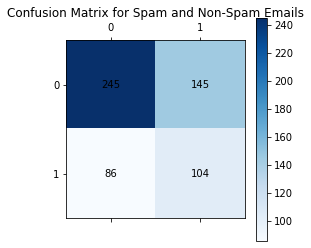

In [43]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="Blues"):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title("Confusion Matrix for Spam and Non-Spam Emails")
    plt.colorbar()
    #tick_marks = np.arrange(len(df_confusion.columns))
    #plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    #plt.yticks(tick_marks, df_confusion.index)
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j,i, f"{z:.0f}", va="center", ha="center")

plot_confusion_matrix(cm)

In [44]:
print('Non-spam emails are labeled as 0 while \nSpam emails are labeled as 1')
print('\n')
print('Sensitivity/Recall: {:.2f}\nSpecificity: {:.2f}\nAccuracy: {:.2f}\nPrecision: {:.2f}\nF1 Score: {:.2f}'.format(sensitivity, specificity, accuracy, precision, fOneScore))

Non-spam emails are labeled as 0 while 
Spam emails are labeled as 1


Sensitivity/Recall: 0.42
Specificity: 0.74
Accuracy: 0.60
Precision: 0.55
F1 Score: 0.47


In [45]:
text_classifier.delete_endpoint()